# Students:
* Ben Belhassen Mohamed Ali (102291)
* Ciampana Lorenzo (102296)
* Filesi Gianluca (102299)

# Home assignment

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A home assignment from a course on Deep Learning at EDHEC.

## Problem statement

The dataset we are interested in here is called "CIFAR10". It is described [in this page](https://keras.io/api/datasets/cifar10/).

You should load the data, **select only 5,000 samples out of the total 50,000 ones**, and preprocess it if needed.
You should compare several candidate neural network architectures, and make a decision about which is best for the task at hand.
You should be explicit about the indicator(s) you base your decision on.

Finally, as a bonus, you could try to evaluate whether it is better to:
* train a model from scratch on this dataset alone ;
* use a large model that was pre-trained on ImageNet ;
* pre-train a model on another dataset called [CIFAR100](https://keras.io/api/datasets/cifar100/) and fine-tune it on CIFAR10.

## Deadline

Deadline for this home assignment is February 28th, 2025.
You should use the link on moodle to hand in your assignment.
A single ipynb file should be provided, with execution traces.
This assignment is to be done **by groups of three, at most** and names of all students should be included in the file name.

## Data loading

You can use the dedicated `keras` utility to load this dataset: <https://keras.io/api/datasets/cifar10/>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras.applications import ResNet50, MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess_input
from keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from keras.applications.resnet50 import ResNet50, decode_predictions
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.datasets import cifar10, cifar100
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, InputLayer, Lambda, MaxPooling2D
from keras.layers.experimental.preprocessing import Resizing
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.utils import to_categorical

2025-02-26 13:49:32.244711: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 13:49:32.248726: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 13:49:32.353150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-26 13:49:32.353750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-26 13:49:32.354969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Dataset loading and sample selection

In [2]:
(X, Y), _ = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [3]:
num_samples = 5000
indices = np.random.choice(X.shape[0], num_samples, replace=False)
X_small = X[indices]
y_small = Y[indices]

## Data preprocessing

In [4]:
X_small = X_small.astype('float32') / 255.0
y_small = to_categorical(y_small, num_classes=10)

In [5]:
# Step 1: Split the data into training (70%) and temporary (30%)
x_train, x_temp, y_train, y_temp = train_test_split(X_small, y_small, test_size=0.3, random_state=42)

# Step 2: Split the temporary set equally into validation (15%) and test (15%)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", x_train.shape)   # Expected ~3500 samples
print("Validation set shape:", x_val.shape)     # Expected ~750 samples
print("Test set shape:", x_test.shape)          # Expected ~750 samples


Training set shape: (3500, 32, 32, 3)
Validation set shape: (750, 32, 32, 3)
Test set shape: (750, 32, 32, 3)


In [6]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train)

# Model architectures

## Callbacks

In [7]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

## Model 1 - MLP

In [8]:
model_1 = Sequential([
    Flatten(input_shape=(32, 32, 3)), # Flatten image from (32,32,3) to a single 1D vector
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(10,  activation='softmax')  # 10 classes in CIFAR10
])

model_1.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=200, validation_data=(x_val, y_val),  callbacks=[es, lr_scheduler],verbose=1)

Epoch 1/200
55/55 [==============================] - 3s 41ms/step - loss: 2.2554 - accuracy: 0.1809 - val_loss: 2.1138 - val_accuracy: 0.2240 - lr: 0.0010
Epoch 2/200
55/55 [==============================] - 2s 39ms/step - loss: 2.0641 - accuracy: 0.2369 - val_loss: 2.0278 - val_accuracy: 0.2787 - lr: 0.0010
Epoch 3/200
55/55 [==============================] - 2s 37ms/step - loss: 1.9925 - accuracy: 0.2720 - val_loss: 1.9955 - val_accuracy: 0.2813 - lr: 0.0010
Epoch 4/200
55/55 [==============================] - 2s 38ms/step - loss: 1.9624 - accuracy: 0.2843 - val_loss: 1.9151 - val_accuracy: 0.2973 - lr: 0.0010
Epoch 5/200
55/55 [==============================] - 2s 38ms/step - loss: 1.9366 - accuracy: 0.2954 - val_loss: 1.8964 - val_accuracy: 0.3173 - lr: 0.0010
Epoch 6/200
55/55 [==============================] - 2s 38ms/step - loss: 1.9291 - accuracy: 0.2954 - val_loss: 1.8916 - val_accuracy: 0.3147 - lr: 0.0010
Epoch 7/200
55/55 [==============================] - 2s 39ms/step - lo

## Model 2 - simple CNN

In [9]:
model_2 = Sequential([
    Conv2D(filters=6, kernel_size=5, padding="valid", activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=2, strides=2),
    Flatten(),
    Dense(units=10, activation='softmax'),
])

model_2.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=200, validation_data=(x_val, y_val),  callbacks=[es, lr_scheduler], verbose=1)

Epoch 1/200
55/55 [==============================] - 3s 48ms/step - loss: 2.1817 - accuracy: 0.1851 - val_loss: 2.0436 - val_accuracy: 0.2307 - lr: 0.0010
Epoch 2/200
55/55 [==============================] - 3s 49ms/step - loss: 2.0045 - accuracy: 0.2791 - val_loss: 1.9225 - val_accuracy: 0.3293 - lr: 0.0010
Epoch 3/200
55/55 [==============================] - 2s 43ms/step - loss: 1.9112 - accuracy: 0.3103 - val_loss: 1.8465 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/200
55/55 [==============================] - 2s 42ms/step - loss: 1.8362 - accuracy: 0.3571 - val_loss: 1.7879 - val_accuracy: 0.3760 - lr: 0.0010
Epoch 5/200
55/55 [==============================] - 2s 43ms/step - loss: 1.8022 - accuracy: 0.3580 - val_loss: 1.7582 - val_accuracy: 0.3840 - lr: 0.0010
Epoch 6/200
55/55 [==============================] - 3s 48ms/step - loss: 1.7570 - accuracy: 0.3663 - val_loss: 1.7244 - val_accuracy: 0.3867 - lr: 0.0010
Epoch 7/200
55/55 [==============================] - 2s 42ms/step - lo

## Model 3 - deeper CNN

In [10]:
model_3 = Sequential([
    Dropout(0.5),
    Conv2D(filters=6, kernel_size=5, padding="valid", activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=2, strides=2),
    Flatten(),
    Dropout(0.7),
    Dense(units=10, activation='softmax'),
])

model_3.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=200, validation_data=(x_val, y_val),  callbacks=[es, lr_scheduler], verbose=1)

Epoch 1/200
55/55 [==============================] - 3s 50ms/step - loss: 2.5375 - accuracy: 0.1040 - val_loss: 2.3020 - val_accuracy: 0.1227 - lr: 0.0010
Epoch 2/200
55/55 [==============================] - 2s 42ms/step - loss: 2.3074 - accuracy: 0.1023 - val_loss: 2.3021 - val_accuracy: 0.1080 - lr: 0.0010
Epoch 3/200
55/55 [==============================] - 2s 42ms/step - loss: 2.2984 - accuracy: 0.1146 - val_loss: 2.3023 - val_accuracy: 0.1080 - lr: 0.0010
Epoch 4/200
55/55 [==============================] - 2s 41ms/step - loss: 2.2891 - accuracy: 0.1166 - val_loss: 2.3020 - val_accuracy: 0.1400 - lr: 0.0010
Epoch 5/200
55/55 [==============================] - 2s 43ms/step - loss: 2.2708 - accuracy: 0.1249 - val_loss: 2.3001 - val_accuracy: 0.1280 - lr: 0.0010
Epoch 6/200
55/55 [==============================] - 2s 42ms/step - loss: 2.2493 - accuracy: 0.1423 - val_loss: 2.2945 - val_accuracy: 0.1347 - lr: 0.0010
Epoch 7/200
55/55 [==============================] - 2s 42ms/step - lo

## Model 4 - deeper CNN

In [11]:
model_4 = Sequential([
    Conv2D(filters=6, kernel_size=5, padding="valid", activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=5, padding="valid", activation="relu"),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(units=120, activation='relu'), 
    Dropout(0.5),
    Dense(units=10, activation='softmax'),
])

model_4.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history_4 = model_4.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=200, validation_data=(x_val, y_val),  callbacks=[es, lr_scheduler], verbose=1)

Epoch 1/200
55/55 [==============================] - 3s 48ms/step - loss: 2.2532 - accuracy: 0.1434 - val_loss: 2.1495 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 2/200
55/55 [==============================] - 3s 47ms/step - loss: 2.1295 - accuracy: 0.2000 - val_loss: 2.0609 - val_accuracy: 0.2507 - lr: 0.0010
Epoch 3/200
55/55 [==============================] - 2s 45ms/step - loss: 2.0874 - accuracy: 0.2186 - val_loss: 2.0262 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 4/200
55/55 [==============================] - 3s 45ms/step - loss: 2.0479 - accuracy: 0.2377 - val_loss: 1.9513 - val_accuracy: 0.2787 - lr: 0.0010
Epoch 5/200
55/55 [==============================] - 2s 44ms/step - loss: 1.9459 - accuracy: 0.2803 - val_loss: 1.8613 - val_accuracy: 0.3240 - lr: 0.0010
Epoch 6/200
55/55 [==============================] - 3s 46ms/step - loss: 1.8703 - accuracy: 0.3063 - val_loss: 1.7455 - val_accuracy: 0.3693 - lr: 0.0010
Epoch 7/200
55/55 [==============================] - 3s 46ms/step - lo

## Model 5 - deeper CNN

In [12]:
model_5 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),  # 512 neurons in first hidden layer
    Dropout(0.5),
    Dense(256, activation='relu'),  # Second hidden layer
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

model_5.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history_5 = model_5.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=200, validation_data=(x_val, y_val),  callbacks=[es, lr_scheduler], verbose=1)

Epoch 1/200
55/55 [==============================] - 6s 97ms/step - loss: 2.2284 - accuracy: 0.1534 - val_loss: 2.0373 - val_accuracy: 0.2280 - lr: 0.0010
Epoch 2/200
55/55 [==============================] - 5s 93ms/step - loss: 2.0150 - accuracy: 0.2437 - val_loss: 1.8164 - val_accuracy: 0.3160 - lr: 0.0010
Epoch 3/200
55/55 [==============================] - 5s 91ms/step - loss: 1.8595 - accuracy: 0.2940 - val_loss: 1.7239 - val_accuracy: 0.3733 - lr: 0.0010
Epoch 4/200
55/55 [==============================] - 5s 92ms/step - loss: 1.7697 - accuracy: 0.3543 - val_loss: 1.6367 - val_accuracy: 0.3747 - lr: 0.0010
Epoch 5/200
55/55 [==============================] - 5s 93ms/step - loss: 1.7152 - accuracy: 0.3563 - val_loss: 1.6338 - val_accuracy: 0.4373 - lr: 0.0010
Epoch 6/200
55/55 [==============================] - 5s 92ms/step - loss: 1.6448 - accuracy: 0.3963 - val_loss: 1.5451 - val_accuracy: 0.4547 - lr: 0.0010
Epoch 7/200
55/55 [==============================] - 5s 91ms/step - lo

## Model 6 - deeper CNN

In [13]:
model_6 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_6.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history_6 = model_6.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=200, validation_data=(x_val, y_val),  callbacks=[es, lr_scheduler], verbose=1)

Epoch 1/200
55/55 [==============================] - 10s 157ms/step - loss: 3.0333 - accuracy: 0.2034 - val_loss: 4.9239 - val_accuracy: 0.1040 - lr: 0.0010
Epoch 2/200
55/55 [==============================] - 8s 152ms/step - loss: 2.4530 - accuracy: 0.2609 - val_loss: 7.2493 - val_accuracy: 0.1027 - lr: 0.0010
Epoch 3/200
55/55 [==============================] - 8s 148ms/step - loss: 2.3445 - accuracy: 0.2954 - val_loss: 8.3626 - val_accuracy: 0.1027 - lr: 0.0010
Epoch 4/200
55/55 [==============================] - 8s 149ms/step - loss: 2.2373 - accuracy: 0.3229 - val_loss: 11.0198 - val_accuracy: 0.1027 - lr: 0.0010
Epoch 5/200
55/55 [==============================] - 8s 154ms/step - loss: 2.1805 - accuracy: 0.3566 - val_loss: 10.4243 - val_accuracy: 0.1040 - lr: 0.0010
Epoch 6/200
55/55 [==============================] - 8s 149ms/step - loss: 2.1070 - accuracy: 0.3774 - val_loss: 6.7075 - val_accuracy: 0.1507 - lr: 0.0010


## Plots

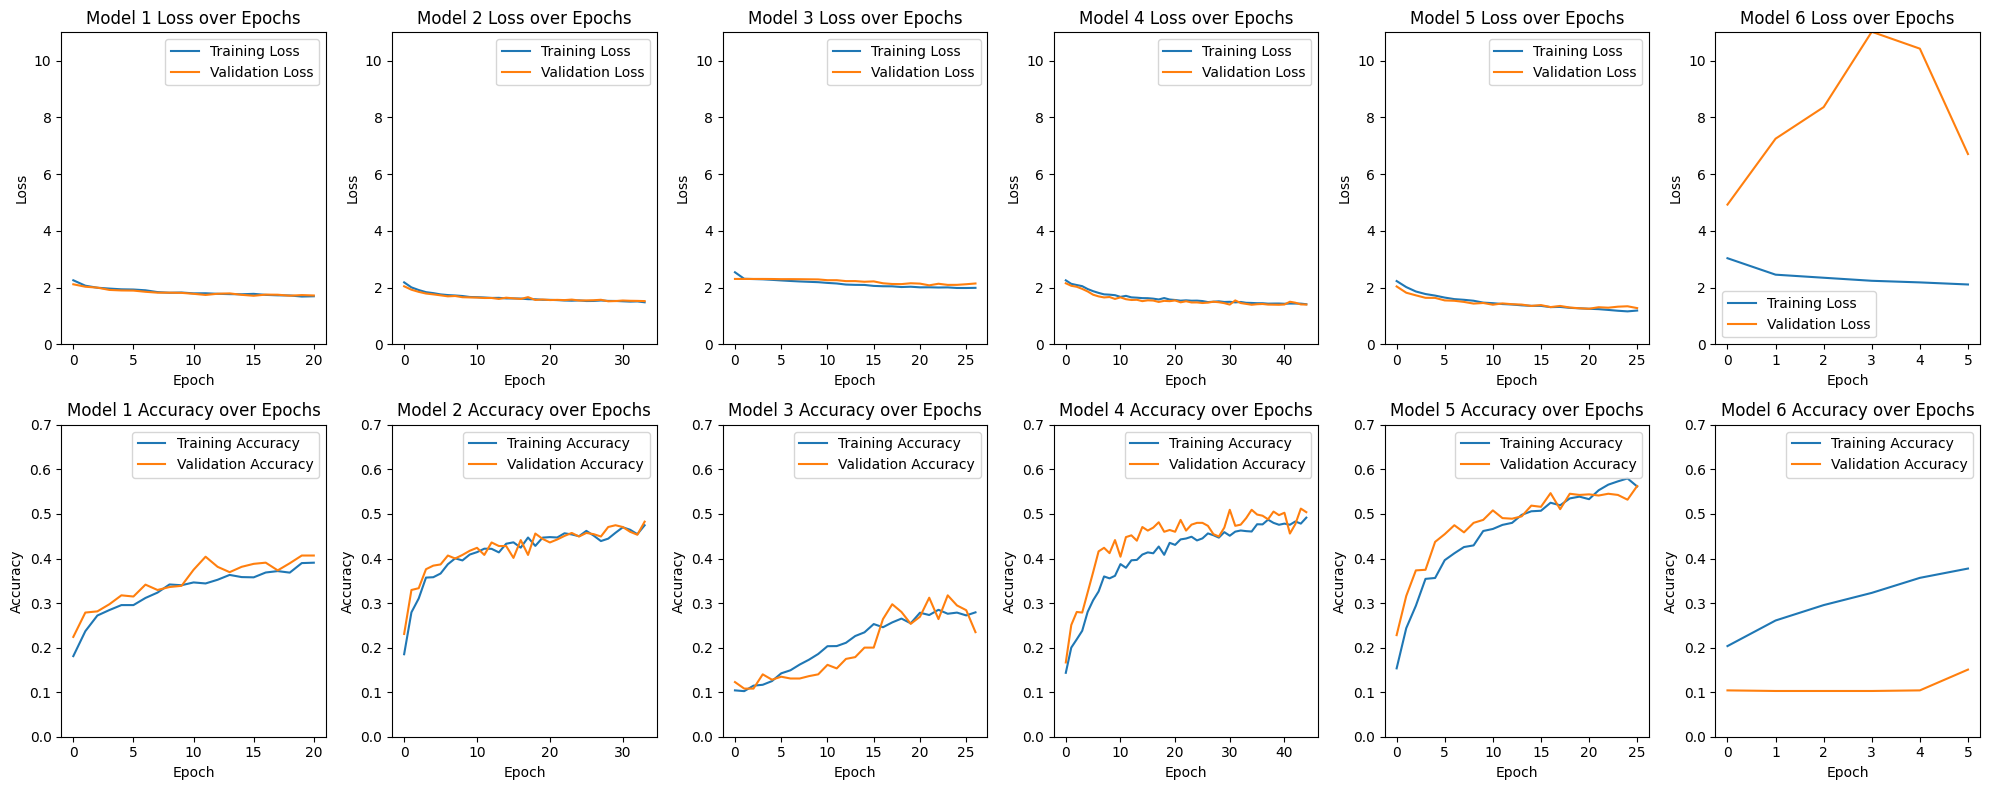

In [14]:
histories = [history_1, history_2, history_3, history_4, history_5, history_6]
plt.figure(figsize=(20, 8))

for i, history in enumerate(histories):
    plt.subplot(2, 6, i+1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model {i+1} Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 11)
    plt.legend()

    plt.subplot(2, 6, i+7)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model {i+1} Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 0.7)
    plt.legend()

plt.tight_layout()
plt.show()

## Models evaluation

In [15]:
models = [model_1, model_2, model_3, model_4, model_5, model_6]
test_loss = []
test_accuracy = []
for model in models:
    loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
    test_loss.append(loss)
    test_accuracy.append(accuracy)

Summary = pd.DataFrame({
    'Model': list(range(1, len(models) + 1)),
    'Test Loss': test_loss,
    'Test Accuracy': test_accuracy
})

Summary

24/24 [==============================] - 0s 16ms/step - loss: 4.8828 - accuracy: 0.0893


,Model,Test Loss,Test Accuracy
0,1,1.727995,0.386667
1,2,1.538454,0.456000
2,3,2.099003,0.282667
3,4,1.430086,0.458667
4,5,1.318334,0.513333
5,6,4.882829,0.089333


# Model from scratch

In [16]:
# Define the enhanced CNN model
model_scr = Sequential()

# Block 1
model_scr.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model_scr.add(BatchNormalization())
model_scr.add(Activation('relu'))
model_scr.add(Conv2D(32, (3, 3), padding='same'))
model_scr.add(BatchNormalization())
model_scr.add(Activation('relu'))
model_scr.add(MaxPooling2D(pool_size=(2, 2)))
model_scr.add(Dropout(0.25))

# Block 2
model_scr.add(Conv2D(64, (3, 3), padding='same'))
model_scr.add(BatchNormalization())
model_scr.add(Activation('relu'))
model_scr.add(Conv2D(64, (3, 3), padding='same'))
model_scr.add(BatchNormalization())
model_scr.add(Activation('relu'))
model_scr.add(MaxPooling2D(pool_size=(2, 2)))
model_scr.add(Dropout(0.25))

# Fully Connected Layers
model_scr.add(Flatten())
model_scr.add(Dense(512))
model_scr.add(BatchNormalization())
model_scr.add(Activation('relu'))
model_scr.add(Dropout(0.5))
model_scr.add(Dense(10, activation='softmax'))

# Compile the model
model_scr.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


# Assuming x_train and x_val are of shape (num_samples, 32, 32, 3)
history_scr = model_scr.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=200, validation_data=(x_val, y_val),  callbacks=[es, lr_scheduler], verbose=1)


Epoch 1/200
55/55 [==============================] - 15s 254ms/step - loss: 2.2417 - accuracy: 0.2714 - val_loss: 2.9667 - val_accuracy: 0.0920 - lr: 0.0010
Epoch 2/200
55/55 [==============================] - 14s 257ms/step - loss: 1.8884 - accuracy: 0.3609 - val_loss: 3.3290 - val_accuracy: 0.1133 - lr: 0.0010
Epoch 3/200
55/55 [==============================] - 14s 250ms/step - loss: 1.7095 - accuracy: 0.3940 - val_loss: 3.4284 - val_accuracy: 0.1400 - lr: 0.0010
Epoch 4/200
55/55 [==============================] - 14s 251ms/step - loss: 1.6460 - accuracy: 0.4183 - val_loss: 3.4261 - val_accuracy: 0.1373 - lr: 0.0010
Epoch 5/200
55/55 [==============================] - 14s 253ms/step - loss: 1.5230 - accuracy: 0.4663 - val_loss: 3.4164 - val_accuracy: 0.1800 - lr: 0.0010
Epoch 6/200
55/55 [==============================] - 14s 250ms/step - loss: 1.4356 - accuracy: 0.4806 - val_loss: 2.6115 - val_accuracy: 0.2613 - lr: 0.0010
Epoch 7/200
55/55 [==============================] - 14s 2

In [17]:
# Evaluate on the test set
test_loss_scr, test_accuracy_scr = model_scr.evaluate(x_test, y_test, verbose=1)
print("Test Loss:", test_loss_scr)
print("Test Accuracy:", test_accuracy_scr)
models.append(model_scr)
test_loss.append(test_loss_scr)
test_accuracy.append(test_accuracy_scr)

24/24 [==============================] - 1s 30ms/step - loss: 1.2229 - accuracy: 0.5760
Test Loss: 1.22292959690094
Test Accuracy: 0.5759999752044678


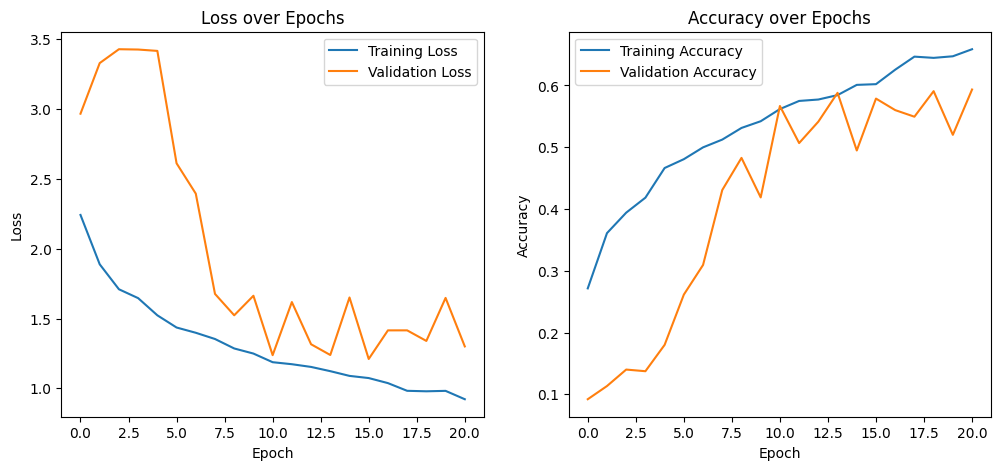

In [18]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_scr.history['loss'], label='Training Loss')
plt.plot(history_scr.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history_scr.history['accuracy'], label='Training Accuracy')
plt.plot(history_scr.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Pre-Trained models

## Res-Net 50

In [19]:
base_model_rn = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_rn.layers:
  layer.trainable = False

model_rn = Sequential([
    Resizing(224, 224, input_shape=(32, 32, 3)),
    Lambda(resnet_preprocess_input),
    base_model_rn,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_rn.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history_rn = model_rn.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=200, validation_data=(x_val, y_val),  callbacks=[es, lr_scheduler], verbose=1)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/200
55/55 [==============================] - 469s 8s/step - loss: 2.4260 - accuracy: 0.1046 - val_loss: 2.2961 - val_accuracy: 0.1173 - lr: 0.0010
Epoch 2/200
38/55 [===================>..........] - ETA: 1:57 - loss: 2.3124 - accuracy: 0.1074

KeyboardInterrupt: 

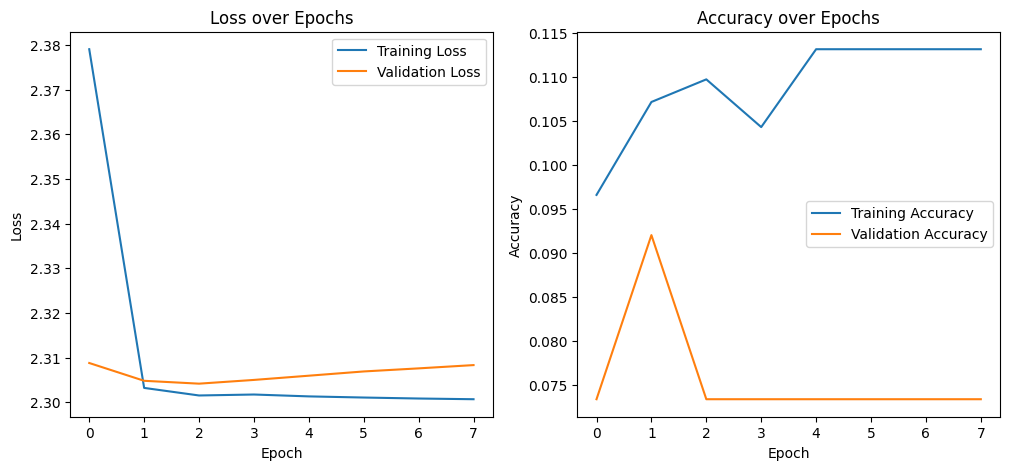

In [49]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_rn.history['loss'], label='Training Loss')
plt.plot(history_rn.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history_rn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate on the test set
test_loss_rn, test_accuracy_rn = model_rn.evaluate(x_test, y_test, verbose=1)
print("Test Loss:", test_loss_rn)
print("Test Accuracy:", test_accuracy_rn)
models.append(model_rn)
test_loss.append(test_loss_rn)
test_accuracy.append(test_accuracy_rn)

24/24 [==============================] - 91s 4s/step - loss: 2.3021 - accuracy: 0.1013
Test Loss: 2.3020524978637695
Test Accuracy: 0.10133333504199982


## Mobile Net V2

In [ ]:
base_model_mn = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_mn.layers:
  layer.trainable = False

model_mn = Sequential([
    Resizing(224, 224, input_shape=(32, 32, 3)),
    Lambda(mobilenet_preprocess_input),
    base_model_mn,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_mn.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history_mn = model_mn.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=200, validation_data=(x_val, y_val),  callbacks=[es, lr_scheduler], verbose=1)

In [ ]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_mn.history['loss'], label='Training Loss')
plt.plot(history_mn.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history_mn.history['accuracy'], label='Training Accuracy')
plt.plot(history_mn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate on the test set
test_loss_mn, test_accuracy_mn = model_mn.evaluate(x_test, y_test, verbose=1)
print("Test Loss:", test_loss_mn)
print("Test Accuracy:", test_accuracy_mn)
models.append(model_mn)
test_loss.append(test_loss_mn)
test_accuracy.append(test_accuracy_mn)

# Pre-Trained model on CIFAR100 and fine-tuned on CIFAR10.

## CIFAR100 data loading

In [ ]:
(x_train100, y_train100), (x_test100, y_test100) = cifar100.load_data()
x_train100 = x_train100.astype('float32') / 255.
x_test100 = x_test100.astype('float32') / 255.
y_train100 = to_categorical(y_train100, 100)
y_test100 = to_categorical(y_test100, 100)

## CIFAR100 model

In [ ]:
model_cifar100 = Sequential([
    InputLayer(input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='softmax')
])

model_cifar100.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',metrics=['accuracy'])
history_cifar100 = model_cifar100.fit(x_train100, y_train100, batch_size=64,epochs=200, validation_data=(x_test100, y_test100), cb=[es,lr_scheduler],verbose=1)

## Fine tuning

In [ ]:
model_cifar10 = Sequential()

for layer in model_cifar100.layers[:-1]:
    model_cifar10.add(layer)

for layer in model_cifar10.layers:
    layer.trainable = False

model_cifar10.add(Dense(10, activation='softmax'))

model_cifar10.compile(optimizer=Adam(learning_rate=1e-3),loss='categorical_crossentropy',metrics=['accuracy'])
history_cifar10 = model_cifar10.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=200, validation_data=(x_val, y_val),  callbacks=[es, lr_scheduler], verbose=1)

In [ ]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(model_cifar10.history['loss'], label='Training Loss')
plt.plot(model_cifar10.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(model_cifar10.history['accuracy'], label='Training Accuracy')
plt.plot(model_cifar10.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate on the test set
test_loss_c10, test_accuracy_c10 = model_cifar10.evaluate(x_test, y_test, verbose=1)
print("Test Loss:", test_loss_c10)
print("Test Accuracy:", test_accuracy_c10)
models.append(model_cifar10)
test_loss.append(test_loss_c10)
test_accuracy.append(test_accuracy_c10)

# Final summary

In [ ]:
histories = histories.append([history_scr, history_rn, history_mn, history_cifar10])
plt.figure(figsize=(20, 8))

for i, history in enumerate(histories):
    plt.subplot(2, 6, i+1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model {i+1} Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 11)
    plt.legend()

    plt.subplot(2, 6, i+7)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model {i+1} Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 0.7)
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
Summary = pd.DataFrame({
    'Model': list(range(1, len(models) + 1)),
    'Test Loss': test_loss,
    'Test Accuracy': test_accuracy
})

Summary

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=07d6bec2-7003-4968-8f46-774f2496fcad' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>